In [1]:
import os
import pickle
from typing import Optional

import matplotlib.pyplot as plt
import numpy as np
from openretina.h5_handling import load_h5_into_dict
from openretina.misc import print_h5_structure
from scipy.interpolate import interp1d
from tqdm.auto import tqdm

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
from openretina.neuron_data_io import upsample_traces

In [3]:
lara_export_path = (
    "/Data/fd_export/2024-03-27_neuron_data_stim_c285329_responses_483c12d.h5"
)
old_export_path = (
    "/Data/fd_export/2024-01-11_neuron_data_stim_c285329_responses_483c12d.pkl"
)
new_export_path = (
    "/Data/fd_export/2024-03-25_neuron_data_responses_484c12d_djimaging.h5"
)

In [4]:
lara_data = load_h5_into_dict(lara_export_path)

Loading HDF5 file contents:   0%|          | 0/1224 [00:00<?, ?item/s]

In [5]:
example_field = "session_1_ventral1_20200226"
old_name = "20200226_1_1"

In [6]:
stim_dataloaders_dict = pickle.load(open(old_export_path, "rb"))

In [7]:
def convert_field_name(example_field):
    parts = example_field.split("_")
    date = parts[-1]
    session = parts[1].split("_")[0]
    ventral = parts[2].split("ventral")[1]
    old_name = f"{date}_{ventral}_{session}"
    return old_name

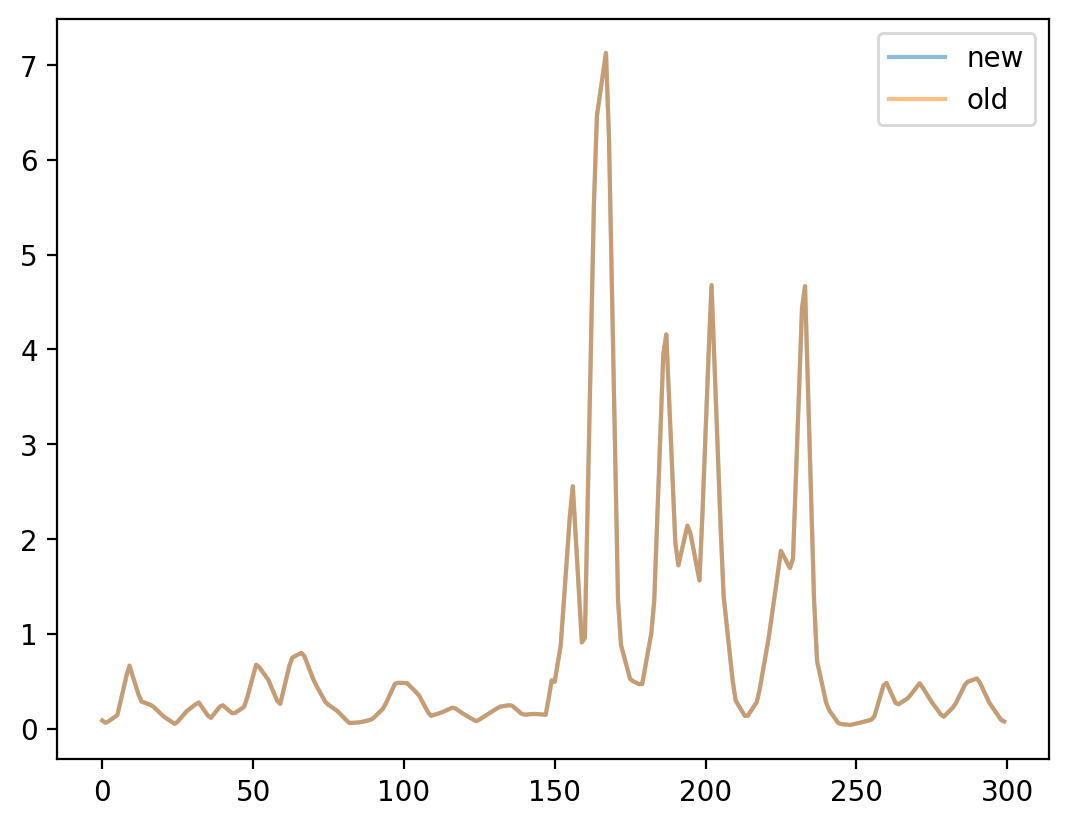

In [9]:
natural_traces = lara_data[example_field]["natural_inferred_spikes"]
natural_triggertimes = lara_data[example_field]["natural_trigger_times"][
    0
]  #! They are all the same!
natural_tracestimes = lara_data[example_field]["natural_traces_times"]

example_upsampled = upsample_traces(
    triggertimes=natural_triggertimes,
    traces=natural_traces,
    tracestimes=natural_tracestimes,
    stim_id=5,
)

plt.plot(example_upsampled[0, :300], label="new", alpha=0.5)
plt.plot(
    stim_dataloaders_dict[convert_field_name(example_field)]["responses_final"][
        0, :300
    ],
    label="old",
    alpha=0.5,
)
plt.legend()

In [10]:
all_same = []

for session in tqdm(lara_data.keys()):
    triggertimes = lara_data[session]["natural_trigger_times"][0]
    natural_traces = lara_data[session]["natural_inferred_spikes"]
    tracestimes = lara_data[session]["natural_traces_times"]
    upsampled_natural = upsample_traces(
        triggertimes=triggertimes,
        traces=natural_traces,
        tracestimes=tracestimes,
        stim_id=5,
    )
    old_field_name = convert_field_name(session)
    try:
        old_data = stim_dataloaders_dict[old_field_name]["responses_final"]
    except KeyError:
        print(f"ATTENTION: Session {session} not found in old data (tried with name {old_field_name})")
        try:
            print("Trying manually with '20200626_2_2'")
            old_data = stim_dataloaders_dict["20200626_2_2"]["responses_final"]
            print("Success!")
            old_field_name = "20200626_2_2"
        except KeyError:
            print("Failed to find manually, skipping")
            continue
    try:
        all_good = np.allclose(upsampled_natural, old_data, rtol=1e-3, atol=1e-3)
        all_same.append(all_good)
        if all_good:
            print(f"Session {session} has the same data as old session {old_field_name}")
        else:
            print(f"ATTENTION: Session {session} has different data than the corresponding {old_field_name}!")
            print(f"    Old data shape: {old_data.shape}, new data shape: {upsampled_natural.shape}")
    except ValueError:
        print(f"ATTENTION: Session {session} has different data!")
        print(f"    Old data shape: {old_data.shape}, new data shape: {upsampled_natural.shape}")

if all(all_same):
    print("All sessions have the same data as the old data")

  0%|          | 0/72 [00:00<?, ?it/s]

Session session_1_ventral1_20200226 has the same data as old session 20200226_1_1
Session session_1_ventral1_20200303 has the same data as old session 20200303_1_1
Session session_1_ventral1_20200528 has the same data as old session 20200528_1_1
Session session_1_ventral1_20200529 has the same data as old session 20200529_1_1
Session session_1_ventral1_20200707 has the same data as old session 20200707_1_1
Session session_1_ventral1_20201021 has the same data as old session 20201021_1_1
Session session_1_ventral1_20201030 has the same data as old session 20201030_1_1
Session session_1_ventral1_20210929 has the same data as old session 20210929_1_1
Session session_1_ventral1_20210930 has the same data as old session 20210930_1_1
Session session_1_ventral2_20200302 has the same data as old session 20200302_2_1
Session session_1_ventral2_20200707 has the same data as old session 20200707_2_1
Session session_1_ventral2_20201021 has the same data as old session 20201021_2_1
Session session_